# CIFAR10 Image classification

## Import libraries

In [72]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorboard import notebook
from IPython.core.display import display, HTML

tf.random.set_seed(42)
np.random.seed(42)

%matplotlib inline

## User defined helper functions

In [73]:
def update_results(name,model,ds_valid):
    '''Update the results.json with current model performance'''
    results = json.load(open('results.json','r'))
    results[name] = model.evaluate(ds_valid)
    json.dump(results, open('results.json','w'))
    print(results)

def display_examples(nums=3):
    '''display examples of images'''
    for i,example in enumerate(ds_train.take(nums)):
        print(label_names[example[-1]], end=' ')
        plt.subplot(100+nums*10+i+1)
        plt.imshow(example[0])
        
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def plot_history(history):
    for metric in history.history:
        plt.plot(history.history[metric],label=metric)
    plt.legend()

def tb_address():
    '''return the address to open tensorboard'''
    tb_port = notebook.manager.get_all()[0].port
    address = "https://jupyter.nersc.gov" + os.environ['JUPYTERHUB_SERVICE_PREFIX'] + 'proxy/' + str(tb_port) + "/"
    address = address.strip()
    display(HTML('<a href="%s">%s</a>'%(address,address)))

## Download and load the dataset

In [74]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
label_names = ds_info.features["label"].names
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



## Show examples

horse deer ship 

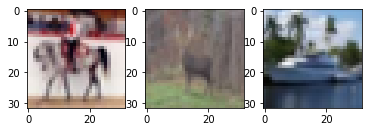

In [75]:
# hand-coded extration
display_examples()

,image,label
0,,7 (horse)
1,,8 (ship)
2,,4 (deer)
3,,6 (frog)

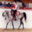
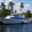
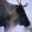
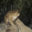

In [76]:
# as pandas dataframe
tfds.as_dataframe(ds_train.take(4), ds_info)

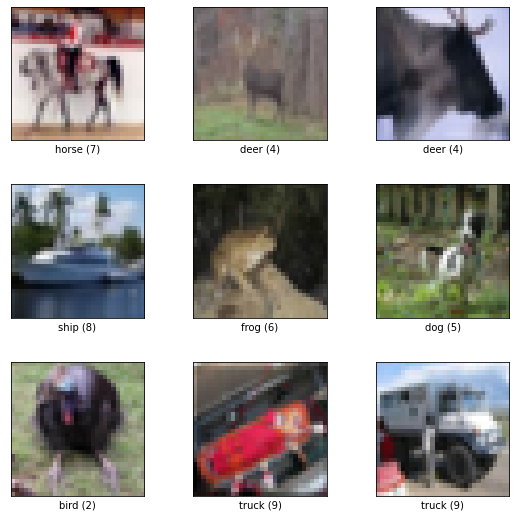

In [77]:
# using show_examples method
fig = tfds.show_examples(ds_train, ds_info)

## DNN Training

In [78]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:80%]','train[80%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [79]:
# train
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train[:80%]'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [80]:
# valid
ds_valid = ds_valid.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.batch(128)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.prefetch(tf.data.experimental.AUTOTUNE)

In [81]:
# test
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [82]:
from tensorflow import keras
from tensorflow.keras.layers import Dense

In [46]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(32,32,3)))
for _ in range(20):
    model.add(Dense(10, activation='elu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='softmax'))

In [47]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

### callbacks

In [48]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [49]:
history = model.fit(ds_train,
          #initial_epoch=181,
          epochs=500,
          validation_data=ds_valid,
          callbacks=callbacks)

Epoch 1/500
1250/1250 [==============================] - 6s 4ms/step - loss: 2.2297 - accuracy: 0.1620 - val_loss: 2.1324 - val_accuracy: 0.1772
Epoch 2/500
1250/1250 [==============================] - 4s 3ms/step - loss: 2.1110 - accuracy: 0.1794 - val_loss: 2.0794 - val_accuracy: 0.1869
Epoch 3/500
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0658 - accuracy: 0.1917 - val_loss: 2.0500 - val_accuracy: 0.2062
Epoch 4/500
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0299 - accuracy: 0.2109 - val_loss: 2.0006 - val_accuracy: 0.2212
Epoch 5/500
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9997 - accuracy: 0.2303 - val_loss: 1.9780 - val_accuracy: 0.2436
Epoch 6/500
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9747 - accuracy: 0.2416 - val_loss: 1.9537 - val_accuracy: 0.2631
Epoch 7/500
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9529 - accuracy: 0.2508 - val_loss: 1.9504 - val_ac

In [46]:
model = keras.models.load_model("my_cifar10_model.h5")
update_results('DNN',model,ds_valid)

79/79 [==============================] - 0s 2ms/step - loss: 1.6754 - accuracy: 0.3901
{'DNN': [1.6754355430603027, 0.39010000228881836], 'DNN-BN': [1.627563238143921, 0.41040000319480896]}


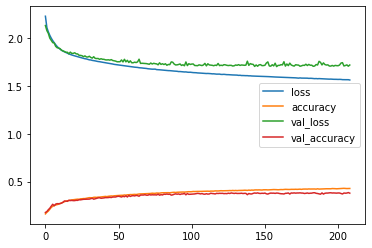

In [64]:
plot_history(history)

## Effect of Batch Normalization

In [84]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(32,32,3)))
model.add(keras.layers.BatchNormalization())  # different
for _ in range(20):
    model.add(Dense(10, kernel_initializer='he_normal')) # different
    model.add(keras.layers.BatchNormalization()) # different
    model.add(keras.layers.Activation("elu")) # different
model.add(Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 2 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

history = model.fit(ds_train,
          #initial_epoch=227,
          epochs=500,
          validation_data=ds_valid,
          callbacks=callbacks)

Epoch 1/500
   2/1250 [..............................] - ETA: 8:41 - loss: 2.4219 - accuracy: 0.1875WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.415479). Check your callbacks.


1250/1250 [==============================] - 11s 9ms/step - loss: 2.3119 - accuracy: 0.1523 - val_loss: 2.2087 - val_accuracy: 0.2104
Epoch 2/500
1250/1250 [==============================] - 9s 7ms/step - loss: 2.1662 - accuracy: 0.2184 - val_loss: 2.0991 - val_accuracy: 0.2466
Epoch 3/500
1250/1250 [==============================] - 8s 6ms/step - loss: 2.0803 - accuracy: 0.2448 - val_loss: 2.0157 - val_accuracy: 0.2720
Epoch 4/500
1250/1250 [==============================] - 8s 6ms/step - loss: 2.0177 - accuracy: 0.2652 - val_loss: 1.9590 - val_accuracy: 0.2813
Epoch 5/500
1250/1250 [==============================] - 8s 7ms/step - loss: 1.9784 - accuracy: 0.2731 - val_loss: 1.9230 - val_accuracy: 0.2956
Epoch 6/500
1250/1250 [==============================] - 8s 7ms/step - loss: 1.9481 - accuracy: 0.2822 - val_loss: 1.8940 - val_accuracy: 0.3021
Epoch 7/500
1250/1250 [==============================] - 8s 7ms/step - loss: 1.9246 - accuracy: 0.2883 - val_loss: 1.8742 - val_accuracy: 0.3

In [ ]:
model = keras.models.load_model("my_cifar10_bn_model.h5")
update_results('DNN-BN',model,ds_valid)

79/79 [==============================] - 0s 2ms/step - loss: 1.6150 - accuracy: 0.4146
{'DNN': [1.6754355430603027, 0.39010000228881836], 'DNN-BN': [1.6149784326553345, 0.4146000146865845]}


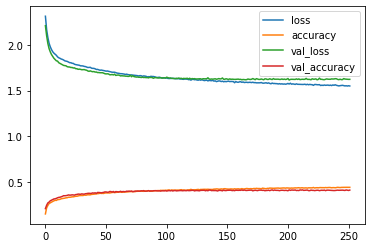

In [ ]:
plot_history(history)